In [1]:
from scipy.cluster.vq import kmeans2
from pyro.infer import MCMC, NUTS, Predictive, SVI, TraceMeanField_ELBO
import pyro
import pyro.contrib.gp as gp
from pyro.contrib.examples.util import get_data_directory, get_data_loader
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load data
train_loader = get_data_loader(dataset_name='MNIST',
                               data_dir='~/.data',
                               batch_size=1000,
                               is_training_set=True,
                               shuffle=True)
test_loader = get_data_loader(dataset_name='MNIST',
                              data_dir='~/.data',
                              batch_size=1000,
                              is_training_set=False,
                              shuffle=False)

downloading data
download complete.
downloading data
download complete.


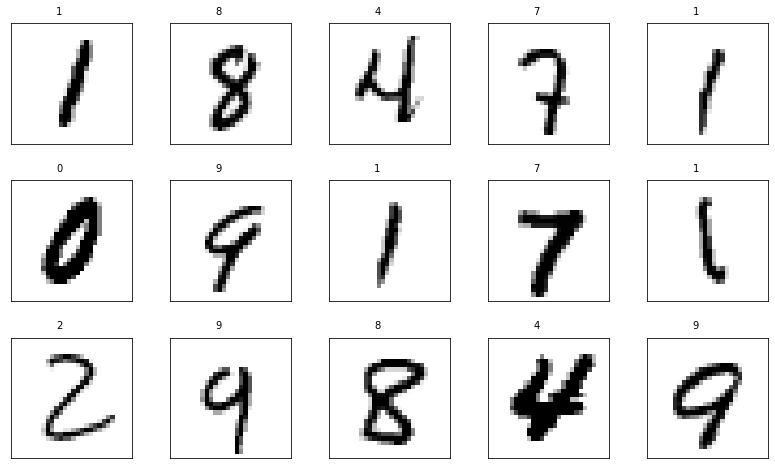

In [3]:
# visualise data set
X = train_loader.dataset.data.float()/255
y = train_loader.dataset.targets
class_names = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

n_rows, n_cols = 3, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8))
inx = np.random.choice(X.shape[0], n_rows*n_cols, replace=False)
fig.subplots_adjust(hspace=0.3, wspace=0.1)

for n, (image, label) in enumerate(zip(X[inx], y[inx])):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(image, cmap='binary')
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    axes[row, col].text(10., -2.5, f'{class_names[label]}')
plt.show()

In [4]:
# scale training data and define target
X = train_loader.dataset.data.reshape(-1, 784).float() / 255
y = train_loader.dataset.targets

In [5]:
# define Linear mean function for SVGP - see Salimbeni and Deisenroth [2017]
class LinearT(nn.Module):
    """Linear transform and transpose"""
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = nn.Linear(dim_in, dim_out, bias=False)

    def forward(self, x):
        return self.linear(x).t()

mean_fn = LinearT(784, 10)

In [6]:
class DeepGP(pyro.nn.PyroModule):
    def __init__(self, X, y, Xu, mean_fn):
        super(DeepGP, self).__init__()
        self.layer1 = gp.models.VariationalSparseGP(
            X,
            y,
            gp.kernels.RBF(784, variance=torch.tensor(2.), lengthscale=torch.tensor(2.)),
            Xu=Xu,
            likelihood=gp.likelihoods.MultiClass(num_classes=10),
            latent_shape=torch.Size([10]))

    def model(self, X, y):
        self.layer1.set_data(X, y)
        self.layer1.model()

    def guide(self, X, y):
        self.layer1.guide()

    # make predictions
    def forward(self, X_new):
        # Predictions are stochastic so make 100 predictions and take most common one
        pred = []
        for _ in range(100):
            h_loc, h_var = self.layer1(X_new)
            h = dist.Normal(h_loc, h_var.sqrt())()
            pred.append(h_loc.argmax(dim=0))
        return torch.stack(pred).mode(dim=0)[0]

In [7]:
# Define inducing points
Xu = torch.from_numpy(kmeans2(X.numpy(), 100, minit='points')[0])

# Model
deepgp = DeepGP(X, y, Xu, mean_fn)

# Set optimizer and loss function to be ELBO
optimizer = torch.optim.Adam(deepgp.parameters(), lr=0.01)
loss_fn = TraceMeanField_ELBO().differentiable_loss

In [8]:
# training step
def train(train_loader, gpmodule, optimizer, loss_fn, epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data, target
        data = data.reshape(-1, 784)
        optimizer.zero_grad()
        loss = loss_fn(gpmodule.model, gpmodule.guide, data, target)
        loss.backward()
        optimizer.step()
        idx = batch_idx + 1
        if idx % 10 == 0:
            print("Train Epoch: {:2d} [{:5d}/{} ({:2.0f}%)]\tLoss: {:.6f}"
                  .format(epoch, idx * len(data), len(train_loader.dataset),
                          100. * idx / len(train_loader), loss))

# test step
def test(test_loader, gpmodule):
    correct = 0
    for data, target in test_loader:
        data, target = data, target
        data = data.reshape(-1, 784)
        pred = gpmodule(data)
        # compare prediction and target to count accuracy
        correct += pred.eq(target).long().cpu().sum().item()

    print("\nTest set: Accuracy: {}/{} ({:.2f}%)\n"
          .format(correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

In [9]:
# Compile
for i in range(20):
    train(train_loader, deepgp, optimizer, loss_fn, i)
    with torch.no_grad():
        test(test_loader, deepgp)

Train Epoch:  0 [10000/60000 (17%)]	Loss: 185841.828125
Train Epoch:  0 [20000/60000 (33%)]	Loss: 174569.359375
Train Epoch:  0 [30000/60000 (50%)]	Loss: 167324.500000
Train Epoch:  0 [40000/60000 (67%)]	Loss: 151897.921875
Train Epoch:  0 [50000/60000 (83%)]	Loss: 124293.953125
Train Epoch:  0 [60000/60000 (100%)]	Loss: 80747.414062

Test set: Accuracy: 8703/10000 (87.03%)

Train Epoch:  1 [10000/60000 (17%)]	Loss: 51755.019531
Train Epoch:  1 [20000/60000 (33%)]	Loss: 41070.628906
Train Epoch:  1 [30000/60000 (50%)]	Loss: 29951.707031
Train Epoch:  1 [40000/60000 (67%)]	Loss: 29953.843750
Train Epoch:  1 [50000/60000 (83%)]	Loss: 29102.341797
Train Epoch:  1 [60000/60000 (100%)]	Loss: 27461.302734

Test set: Accuracy: 9277/10000 (92.77%)

Train Epoch:  2 [10000/60000 (17%)]	Loss: 24687.400391
Train Epoch:  2 [20000/60000 (33%)]	Loss: 26935.376953
Train Epoch:  2 [30000/60000 (50%)]	Loss: 24679.339844
Train Epoch:  2 [40000/60000 (67%)]	Loss: 25817.419922
Train Epoch:  2 [50000/60000 